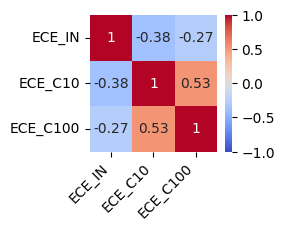

In [115]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import ast

df = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_pre.csv')

title_font_size = 22
axis_label_font_size = 18
tick_label_font_size = 16
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau


# Filter the rows for the datasets of interest
datasets = ['ImageNet16-120', 'cifar10', 'cifar100']
labels = ['ECE_IN', 'ECE_C10', 'ECE_C100']

ece_values = {}

# Extract the ECE value for 15 bins for each dataset and store in a dictionary
for dataset in datasets:
    ece_values[dataset] = df[df['dataset'] == dataset]['ece'].apply(
        lambda x: [entry['result'] for entry in ast.literal_eval(x) if entry['n_bins'] == 15].pop()
    ).tolist()

# Convert the dictionary to a dataframe
ece_df = pd.DataFrame(ece_values)
# Assume ece_df is your DataFrame and the datasets are the columns


datasets = ece_df.columns.tolist()

# Create new columns with the ranking of each metric for each dataset
for dataset in datasets:
    rank_column_name = f"rank_{dataset}"
    ece_df[rank_column_name] = ece_df[dataset].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"rank_{dataset}" for dataset in datasets]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(ece_df[col1], ece_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Adjust column and index names to reflect the ECE metric
ece_labels = ['ECE_IN', 'ECE_C10', 'ECE_C100']
corr_matrix.columns = ece_labels
corr_matrix.index = ece_labels

# You can adjust selected_datasets if you only want a subset
selected_datasets = ece_labels  # this will select all datasets
corr_matrix_selected = corr_matrix.loc[selected_datasets, selected_datasets]

# Create a correlation heatmap using seaborn
plt.figure(figsize=(2.045, 1.773))
sns.heatmap(corr_matrix_selected.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

# If you want to save the figure
plt.savefig("fig/ICLR2024/Kendall_ECE15_pre.pdf", dpi=300, format='pdf', bbox_inches='tight')

plt.show()

In [116]:


import pandas as pd
df = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_pre.csv')
df = df.loc[df['dataset']=='cifar10']
# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['acc']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df[['test-accuracy','15_bins','100_bins', '200_bins', '500_bins']]

df_post = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_post.csv')
df_post = df_post.loc[df_post['dataset']=='cifar10']

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecepost_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_post.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}
    for item in ecepost_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['acc']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecepost_df = pd.concat([ecepost_df, data_to_append], ignore_index=True)

plotpost_df = ecepost_df[['15_bins','100_bins', '200_bins', '500_bins']]


In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df and plotpost_df
bin_columns = ['15_bins', '100_bins', '200_bins', '500_bins']

# Rename columns in plotpost_df to have a '_post' suffix
plotpost_df = plotpost_df.rename(columns={col: f"{col} post" for col in bin_columns})

# Combine both DataFrames
combined_df = pd.concat([plot_df, plotpost_df], axis=1)

combined_df = combined_df.nlargest(1000, 'test-accuracy')[['15_bins', '100_bins', '200_bins', '500_bins' ,'15_bins post', '100_bins post', '200_bins post', '500_bins post']]

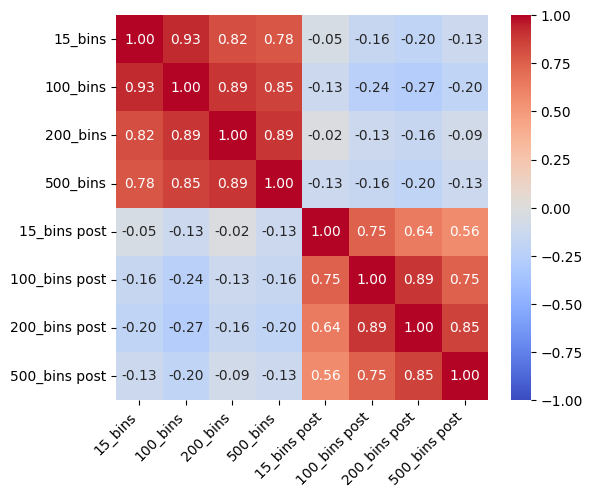

In [118]:
# Calculate the Kendall ranking correlation matrix for the combined DataFrame
all_columns = bin_columns + [f"{col} post" for col in bin_columns]
corr_matrix = pd.DataFrame(index=all_columns, columns=all_columns)


for col1 in all_columns:
    for col2 in all_columns:
        corr, _ = nansafe_kendalltau(combined_df[col1], combined_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
# plt.title("ImageNet ECE Kendall Ranking Correlation Heatmap ")

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/ICLR2024/Kendall_temp_cifar10.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

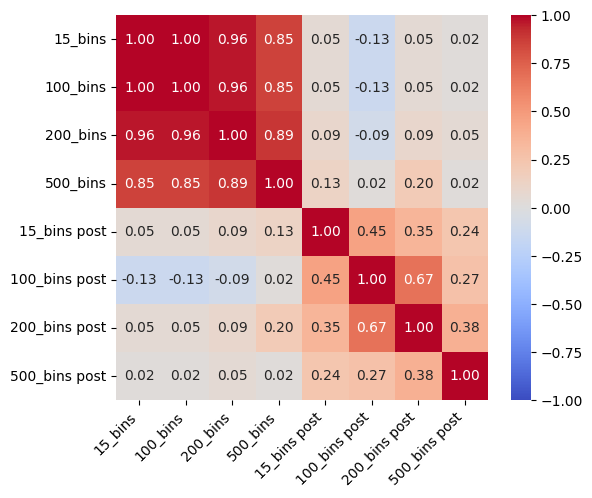

In [119]:


import pandas as pd
df = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_pre.csv')
df = df.loc[df['dataset']=='ImageNet16-120']
# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['acc']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df[['test-accuracy','15_bins','100_bins', '200_bins', '500_bins']]

df_post = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_post.csv')
df_post = df_post.loc[df_post['dataset']=='ImageNet16-120']

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecepost_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_post.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}
    for item in ecepost_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['acc']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecepost_df = pd.concat([ecepost_df, data_to_append], ignore_index=True)

plotpost_df = ecepost_df[['15_bins','100_bins', '200_bins', '500_bins']]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df and plotpost_df
bin_columns = ['15_bins', '100_bins', '200_bins', '500_bins']

# Rename columns in plotpost_df to have a '_post' suffix
plotpost_df = plotpost_df.rename(columns={col: f"{col} post" for col in bin_columns})

# Combine both DataFrames
combined_df = pd.concat([plot_df, plotpost_df], axis=1)

combined_df = combined_df.nlargest(1000, 'test-accuracy')[['15_bins', '100_bins', '200_bins', '500_bins' ,'15_bins post', '100_bins post', '200_bins post', '500_bins post']]

# Calculate the Kendall ranking correlation matrix for the combined DataFrame
all_columns = bin_columns + [f"{col} post" for col in bin_columns]
corr_matrix = pd.DataFrame(index=all_columns, columns=all_columns)


for col1 in all_columns:
    for col2 in all_columns:
        corr, _ = nansafe_kendalltau(combined_df[col1], combined_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
# plt.title("ImageNet ECE Kendall Ranking Correlation Heatmap ")

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/ICLR2024/Kendall_temp_IN.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

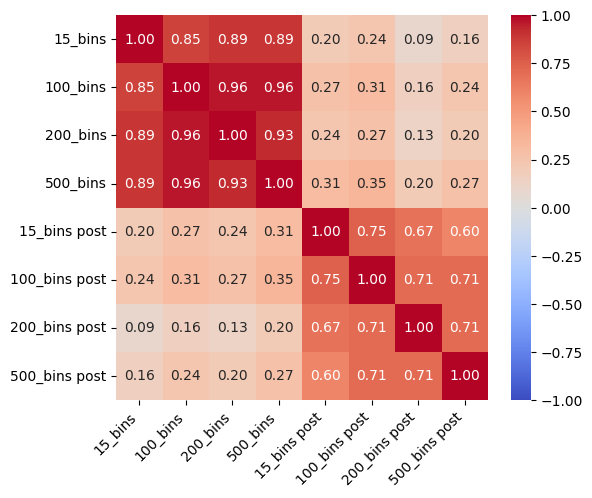

In [120]:


import pandas as pd
df = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_pre.csv')
df = df.loc[df['dataset']=='cifar100']
# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['acc']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df[['test-accuracy','15_bins','100_bins', '200_bins', '500_bins']]

df_post = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_post.csv')
df_post = df_post.loc[df_post['dataset']=='cifar100']

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecepost_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_post.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}
    for item in ecepost_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['acc']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecepost_df = pd.concat([ecepost_df, data_to_append], ignore_index=True)

plotpost_df = ecepost_df[['15_bins','100_bins', '200_bins', '500_bins']]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df and plotpost_df
bin_columns = ['15_bins', '100_bins', '200_bins', '500_bins']

# Rename columns in plotpost_df to have a '_post' suffix
plotpost_df = plotpost_df.rename(columns={col: f"{col} post" for col in bin_columns})

# Combine both DataFrames
combined_df = pd.concat([plot_df, plotpost_df], axis=1)

combined_df = combined_df.nlargest(1000, 'test-accuracy')[['15_bins', '100_bins', '200_bins', '500_bins' ,'15_bins post', '100_bins post', '200_bins post', '500_bins post']]

# Calculate the Kendall ranking correlation matrix for the combined DataFrame
all_columns = bin_columns + [f"{col} post" for col in bin_columns]
corr_matrix = pd.DataFrame(index=all_columns, columns=all_columns)


for col1 in all_columns:
    for col2 in all_columns:
        corr, _ = nansafe_kendalltau(combined_df[col1], combined_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
# plt.title("ImageNet ECE Kendall Ranking Correlation Heatmap ")

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/ICLR2024/Kendall_temp_cifar100.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
df = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_pre.csv')

# Filter the rows for the datasets of interest
datasets = ['ImageNet16-120', 'cifar10', 'cifar100']
labels = ['_IN', '_C10', '_C100']

# ece_values = {}


dataset_suffix_mapping = {
    'ImageNet16-120': '_IN',
    'cifar10': '_C10',
    'cifar100': '_C100'
}

metrics_to_extract = [
    'ece', 'ECE_em', 'cwECE', 'ace', 'KSCE', 'KDECE', 'MMCE'
]


def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

# Assuming new_df is your original DataFrame
new_df_imagenet = df[df['dataset'] == 'ImageNet16-120'].set_index('config')
new_df_cifar10 = df[df['dataset'] == 'cifar10'].set_index('config')
new_df_cifar100 = df[df['dataset'] == 'cifar100'].set_index('config')



def process_dataset_df(df, dataset_suffix):
    extracted_df = pd.DataFrame(index=df.index)
    for metric in metrics_to_extract:
        column_name = f"{metric}{dataset_suffix}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))
        extracted_df[column_name] = df[column_name]  # copy the values to extracted_df
    return extracted_df

# Process each dataset DataFrame
extracted_imagenet = process_dataset_df(new_df_imagenet, '_IN')
extracted_cifar10 = process_dataset_df(new_df_cifar10, '_C10')
extracted_cifar100 = process_dataset_df(new_df_cifar100, '_C100')

metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE','cwCE_em', 'KSCE', 'KDECE', 'MMCE'
]

col_rename_dict_imagenet = {old: new + '_IN' for old, new in zip(extracted_imagenet.columns, metrics_to_extract)}
col_rename_dict_cifar10 = {old: new + '_C10' for old, new in zip(extracted_cifar10.columns, metrics_to_extract)}
col_rename_dict_cifar100 = {old: new + '_C100' for old, new in zip(extracted_cifar100.columns, metrics_to_extract)}

extracted_imagenet.rename(columns=col_rename_dict_imagenet, inplace=True)
extracted_cifar10.rename(columns=col_rename_dict_cifar10, inplace=True)
extracted_cifar100.rename(columns=col_rename_dict_cifar100, inplace=True)

# Merge the extracted DataFrames back together on the 'config' column using an outer merge
merged_df = pd.merge(extracted_imagenet, extracted_cifar10, on='config', how='outer')
merged_df = pd.merge(merged_df, extracted_cifar100, on='config', how='outer')

# Merge the extracted DataFrames back together on the index




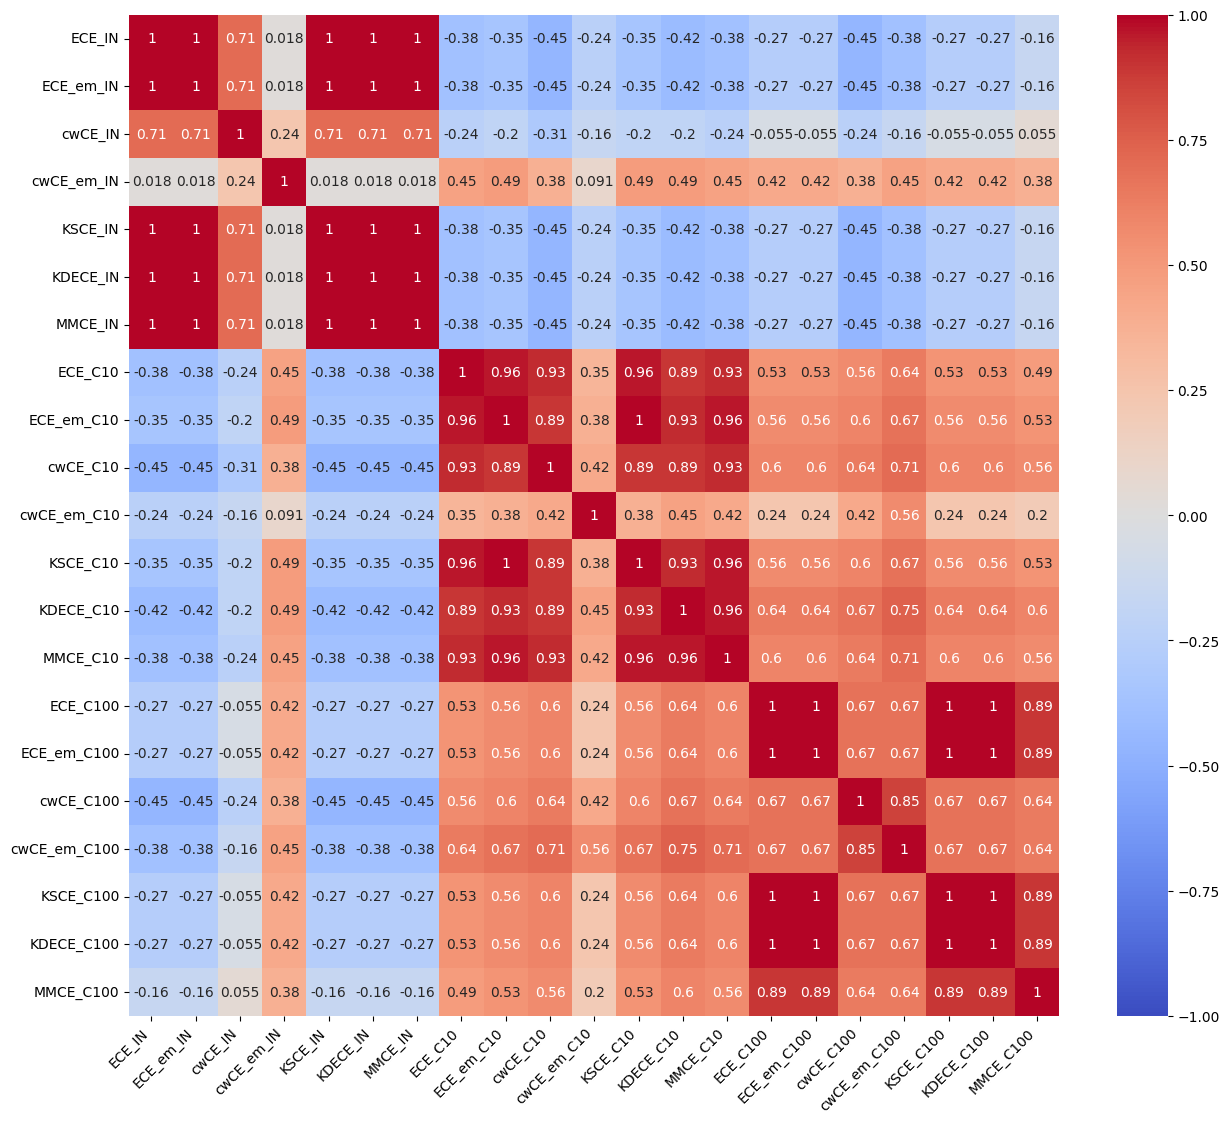

In [122]:
for metric in metrics_to_extract:
    for dataset in ['IN', 'C10', 'C100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN', 'C10', 'C100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/ICLR2024/Kendall_all_pre.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

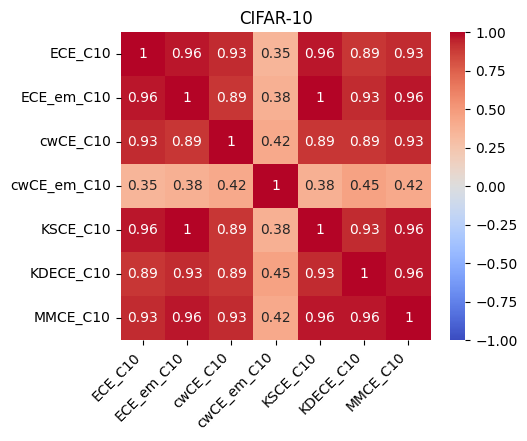

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
df = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_pre.csv')

# Filter the rows for the datasets of interest
datasets = ['ImageNet16-120', 'cifar10', 'cifar100']
labels = ['_IN', '_C10', '_C100']

# ece_values = {}


dataset_suffix_mapping = {
    'ImageNet16-120': '_IN',
    'cifar10': '_C10',
    'cifar100': '_C100'
}

metrics_to_extract = [
    'ece', 'ECE_em', 'cwECE', 'ace', 'KSCE', 'KDECE', 'MMCE'
]


def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

# Assuming new_df is your original DataFrame
new_df_cifar10 = df[df['dataset'] == 'cifar10'].set_index('config')



def process_dataset_df(df, dataset_suffix):
    extracted_df = pd.DataFrame(index=df.index)
    for metric in metrics_to_extract:
        column_name = f"{metric}{dataset_suffix}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))
        extracted_df[column_name] = df[column_name]  # copy the values to extracted_df
    return extracted_df

# Process each dataset DataFrame
extracted_cifar10 = process_dataset_df(new_df_cifar10, '_C10')

metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE','cwCE_em', 'KSCE', 'KDECE', 'MMCE'
]

col_rename_dict_cifar10 = {old: new + '_C10' for old, new in zip(extracted_cifar10.columns, metrics_to_extract)}

extracted_cifar10.rename(columns=col_rename_dict_cifar10, inplace=True)

# Merge the extracted DataFrames back together on the 'config' column using an outer merge
merged_df = extracted_cifar10

# Merge the extracted DataFrames back together on the index

for metric in metrics_to_extract:
    for dataset in ['C10']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['C10'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.title('CIFAR-10')
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/ICLR2024/vit_cifar10_pre.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


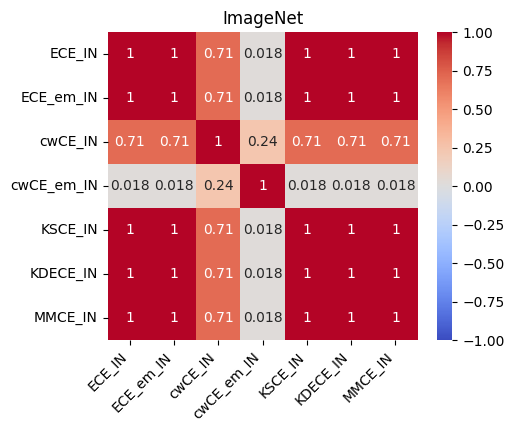

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
df = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_pre.csv')

# Filter the rows for the datasets of interest
datasets = ['ImageNet16-120', 'cifar10', 'cifar100']
labels = ['_IN', '_C10', '_C100']

# ece_values = {}


dataset_suffix_mapping = {
    'ImageNet16-120': '_IN',
    'cifar10': '_C10',
    'cifar100': '_C100'
}

metrics_to_extract = [
    'ece', 'ECE_em', 'cwECE', 'ace', 'KSCE', 'KDECE', 'MMCE'
]


def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

# Assuming new_df is your original DataFrame
new_df_cifar10 = df[df['dataset'] == 'ImageNet16-120'].set_index('config')



def process_dataset_df(df, dataset_suffix):
    extracted_df = pd.DataFrame(index=df.index)
    for metric in metrics_to_extract:
        column_name = f"{metric}{dataset_suffix}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))
        extracted_df[column_name] = df[column_name]  # copy the values to extracted_df
    return extracted_df

# Process each dataset DataFrame
extracted_cifar10 = process_dataset_df(new_df_cifar10, '_IN')

metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE','cwCE_em', 'KSCE', 'KDECE', 'MMCE'
]

col_rename_dict_cifar10 = {old: new + '_IN' for old, new in zip(extracted_cifar10.columns, metrics_to_extract)}

extracted_cifar10.rename(columns=col_rename_dict_cifar10, inplace=True)

# Merge the extracted DataFrames back together on the 'config' column using an outer merge
merged_df = extracted_cifar10

# Merge the extracted DataFrames back together on the index

for metric in metrics_to_extract:
    for dataset in ['IN']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.title('ImageNet')
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/ICLR2024/vit_imagenet_pre.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


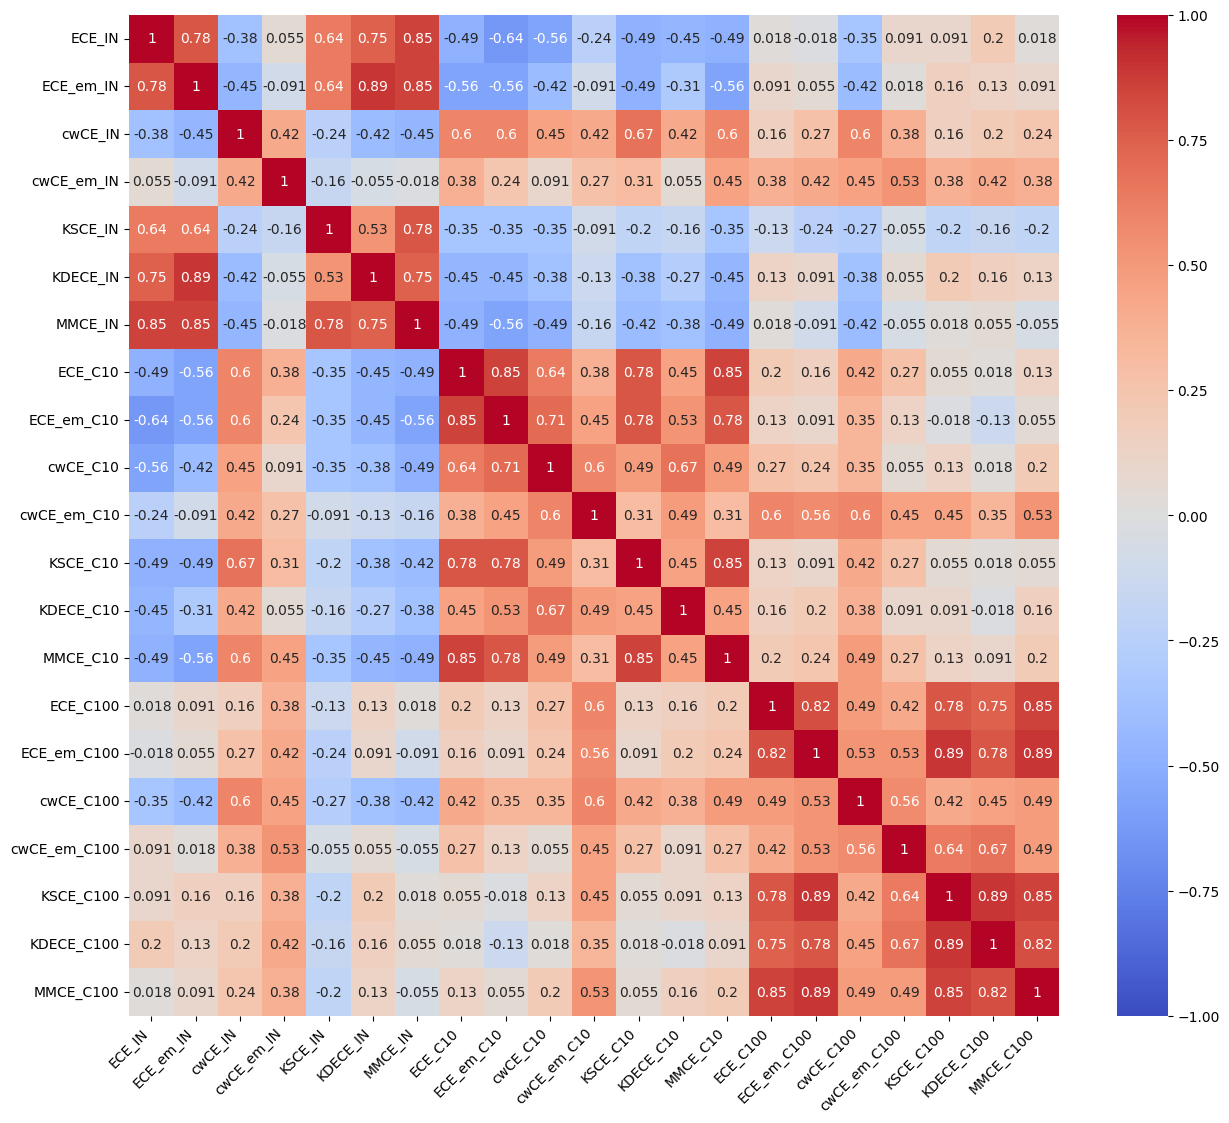

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
df = pd.read_csv('/home/younan/project_calibration/project_calibration/final_results/ICLR2024/results_post.csv')

# Filter the rows for the datasets of interest
datasets = ['ImageNet16-120', 'cifar10', 'cifar100']
labels = ['_IN', '_C10', '_C100']

# ece_values = {}


dataset_suffix_mapping = {
    'ImageNet16-120': '_IN',
    'cifar10': '_C10',
    'cifar100': '_C100'
}

metrics_to_extract = [
    'ece', 'ECE_em', 'cwECE', 'ace', 'KSCE', 'KDECE', 'MMCE'
]


def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

# Assuming new_df is your original DataFrame
new_df_imagenet = df[df['dataset'] == 'ImageNet16-120'].set_index('config')
new_df_cifar10 = df[df['dataset'] == 'cifar10'].set_index('config')
new_df_cifar100 = df[df['dataset'] == 'cifar100'].set_index('config')



def process_dataset_df(df, dataset_suffix):
    extracted_df = pd.DataFrame(index=df.index)
    for metric in metrics_to_extract:
        column_name = f"{metric}{dataset_suffix}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))
        extracted_df[column_name] = df[column_name]  # copy the values to extracted_df
    return extracted_df

# Process each dataset DataFrame
extracted_imagenet = process_dataset_df(new_df_imagenet, '_IN')
extracted_cifar10 = process_dataset_df(new_df_cifar10, '_C10')
extracted_cifar100 = process_dataset_df(new_df_cifar100, '_C100')

metrics_to_extract = [
    'ECE', 'ECE_em', 'cwCE','cwCE_em', 'KSCE', 'KDECE', 'MMCE'
]

col_rename_dict_imagenet = {old: new + '_IN' for old, new in zip(extracted_imagenet.columns, metrics_to_extract)}
col_rename_dict_cifar10 = {old: new + '_C10' for old, new in zip(extracted_cifar10.columns, metrics_to_extract)}
col_rename_dict_cifar100 = {old: new + '_C100' for old, new in zip(extracted_cifar100.columns, metrics_to_extract)}

extracted_imagenet.rename(columns=col_rename_dict_imagenet, inplace=True)
extracted_cifar10.rename(columns=col_rename_dict_cifar10, inplace=True)
extracted_cifar100.rename(columns=col_rename_dict_cifar100, inplace=True)

# Merge the extracted DataFrames back together on the 'config' column using an outer merge
merged_df = pd.merge(extracted_imagenet, extracted_cifar10, on='config', how='outer')
merged_df = pd.merge(merged_df, extracted_cifar100, on='config', how='outer')

# Merge the extracted DataFrames back together on the index


for metric in metrics_to_extract:
    for dataset in ['IN', 'C10', 'C100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN', 'C10', 'C100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/ICLR2024/Kendall_all_post.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()